In [27]:
from PIL import Image
from skimage import measure
from skimage import color
import numpy as np 
import pandas as pd 
import os
import sys
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=34)
from pathlib import Path
import matplotlib
sns.set(font_scale=2)
%matplotlib inline

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [30]:
from config import *
import my_io as io

In [31]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split('\\')[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [32]:
conditions = ['Disease']*6 + ['Healthy']*6

# Get stats

In [33]:
df = pd.DataFrame()
for n, dataset in enumerate(datasets):
    markers = []
    imgs = []    
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
        for name in sorted(filenames):
            if 'tiff' in name and dataset in name:
                img = cv2.imread(os.path.join(dirpath,name),flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))
                imgs.append(img)
                markers.append(name.split('_')[1].split('.')[0])
                

    for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
        for name in sorted(filenames):
            if 'tiff' in name and dataset in name:        
                img = cv2.imread(os.path.join(dirpath,name),0)
                masks.append(img)
                
    # Read cell mask image 
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if  'tiff' in name and dataset in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath,name)))
            
    max_cell = len(np.unique(cell_mask))
    
    # Read mean intensity of marker in cell 
    marker_area = {}
    for idx, marker in enumerate(markers):
        marker_area[marker] = [len(np.unique(cv2.bitwise_and(cell_mask,cell_mask, mask=masks[idx]))) / max_cell]
        
    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp['ROI'] = dataset
    df = df.append(df_temp, ignore_index=True)

df = df.drop(columns=['CD44', 'H3K9me3', 'MHCII'])

In [38]:
df.set_index('ROI', inplace=True)
df.head()

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,DNA1,DNA2,Ecadherin,FoxP3,GranzymeB,Histone3,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin
ROI,,,,,,,,,,,,,,,,,,,
DT1,0.552816,0.442460,0.457072,0.748698,0.367396,0.352918,0.084003,0.991790,0.993555,0.195904,0.011234,0.226847,0.927231,0.298557,0.634789,0.086011,0.085393,0.610223,0.561512
DT2,0.447063,0.357655,0.411101,0.912694,0.653410,0.300248,0.140375,0.968574,0.971982,0.126765,0.022861,0.277586,0.895233,0.139556,0.811889,0.143606,0.105475,0.091090,0.739078
DT3,0.286203,0.240380,0.301941,0.800970,0.451031,0.123835,0.154241,0.998485,0.999198,0.227690,0.078725,0.163687,0.680985,0.059743,0.001836,0.000428,0.166200,0.025933,0.523464
DT4,0.483644,0.547635,0.521451,0.815544,0.155954,0.188507,0.058790,0.995577,0.996267,0.339490,0.114272,0.034906,0.901067,0.200485,0.037383,0.013110,0.107832,0.703961,0.424588
DT5,0.604307,0.649146,0.537125,0.937858,0.517896,0.599319,0.287078,0.995924,0.997437,0.129547,0.116286,0.314184,0.955849,0.153919,0.874013,0.088956,0.018283,0.111281,0.375449


# Visualization

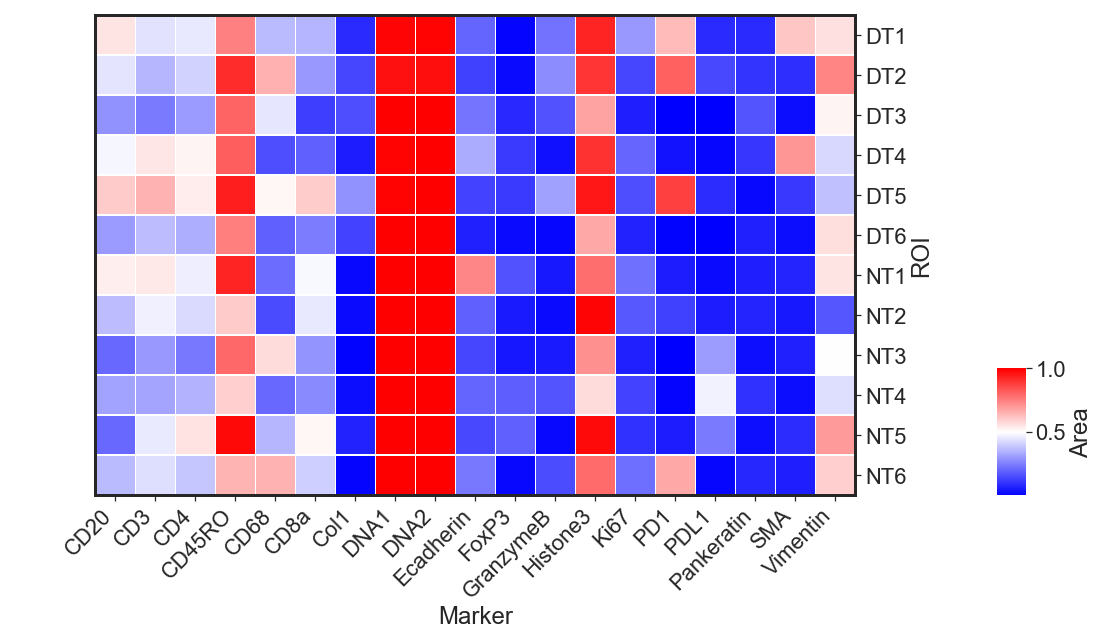

In [53]:
cellSizePixels=40
my_cmap = 'bwr'
scale_name = 'Area'

# Calulate the figure size, this gets us close, but not quite to the right place
dpi = matplotlib.rcParams['figure.dpi']
marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
Ny,Nx = df.shape
figWidth = (Nx*cellSizePixels/dpi)/marginWidth
figHeigh = (Ny*cellSizePixels/dpi)/marginHeight

with sns.axes_style("white"):
    ax = sns.clustermap(df,
                        cmap=my_cmap,
                        linewidth=0.5,
                        col_cluster=False,
                        row_cluster=False,
                        dendrogram_ratio=(0.1, 0.0),
                        figsize=(figWidth, figHeigh))
    
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_yticklabels(), rotation=0)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.ax_heatmap.set_xlabel('Marker')
ax.ax_heatmap.set_ylabel('ROI')
ax.ax_heatmap.tick_params(bottom=True)

# calculate the size of the heatmap axes
axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

# resize heatmap
ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
ax.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                              axWidth, axHeight])

# resize dendrograms to match
ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
ax.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                     ax_row_orig_pos.width, axHeight])

pos = ax.ax_heatmap.get_position()
cbar_size=0.2
ax.ax_cbar.set_position((1.02, pos.y0, .03, cbar_size))

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=24)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)